In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, CuDNNLSTM
import math
from sklearn.metrics import mean_squared_error


In [221]:
#Uploading the covid-19 dataset...
dataset=pd.read_csv('owid-covid-data.csv')

In [4]:
dataset.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


# Data Preparation

In [220]:
#Select related locations:
data_USA=dataset[dataset['location']=='United States']
data_Canada=dataset[dataset['location']=='Canada']
data_World=dataset[dataset['location']=='World']

In [6]:
data_USA['date'].head()

130487    2020-01-22
130488    2020-01-23
130489    2020-01-24
130490    2020-01-25
130491    2020-01-26
Name: date, dtype: object

In [7]:
data_Canada['date'].head()

21904    2020-01-26
21905    2020-01-27
21906    2020-01-28
21907    2020-01-29
21908    2020-01-30
Name: date, dtype: object

In [8]:
print(data_USA.shape)
print(data_Canada.shape)
print(data_World.shape)

(685, 67)
(681, 67)
(685, 67)


In [9]:
#Extract data with identical date times:

New_data_USA=data_USA.iloc[data_USA.shape[0]-data_Canada.shape[0]:]
New_data_World=data_World.iloc[data_World.shape[0]-data_Canada.shape[0]:]

print('Shapes of the 3 datasets:')
print(New_data_USA.shape)
print(data_Canada.shape)
print(New_data_World.shape)


#Check if all dates are identical?
print('Is there is any differences in the dates?', 0 in (New_data_USA['date'].values==data_Canada['date'].values) or 0 in (New_data_World['date'].values==data_Canada['date'].values))

Shapes of the 3 datasets:
(681, 67)
(681, 67)
(681, 67)
Is there is any differences in the dates? False


In [10]:
#We want to focus only on the new cases:

df={ 'Date': data_Canada['date'],
    'World': New_data_World['new_cases_smoothed'].values,
    'United States':New_data_USA['new_cases_smoothed'].values,
    'Canada':data_Canada['new_cases_smoothed'].values    
}

df=pd.DataFrame(df)
df.index=pd.to_datetime(df.Date)

In [11]:
df.info

<bound method DataFrame.info of                   Date       World  United States    Canada
Date                                                       
2020-01-26  2020-01-26         NaN            NaN       NaN
2020-01-27  2020-01-27         NaN            NaN       NaN
2020-01-28  2020-01-28     717.286          0.571       NaN
2020-01-29  2020-01-29     801.429          0.714       NaN
2020-01-30  2020-01-30    1082.857          0.714       NaN
...                ...         ...            ...       ...
2021-12-02  2021-12-02  592886.857     100972.714  2824.286
2021-12-03  2021-12-03  610500.143     116230.000  2892.286
2021-12-04  2021-12-04  618545.714     121438.143  2963.286
2021-12-05  2021-12-05  621048.143     120494.000  3057.143
2021-12-06  2021-12-06  610629.429     119913.714  3168.286

[681 rows x 4 columns]>

In [12]:
df=df.fillna(0)
df.info

<bound method DataFrame.info of                   Date       World  United States    Canada
Date                                                       
2020-01-26  2020-01-26       0.000          0.000     0.000
2020-01-27  2020-01-27       0.000          0.000     0.000
2020-01-28  2020-01-28     717.286          0.571     0.000
2020-01-29  2020-01-29     801.429          0.714     0.000
2020-01-30  2020-01-30    1082.857          0.714     0.000
...                ...         ...            ...       ...
2021-12-02  2021-12-02  592886.857     100972.714  2824.286
2021-12-03  2021-12-03  610500.143     116230.000  2892.286
2021-12-04  2021-12-04  618545.714     121438.143  2963.286
2021-12-05  2021-12-05  621048.143     120494.000  3057.143
2021-12-06  2021-12-06  610629.429     119913.714  3168.286

[681 rows x 4 columns]>

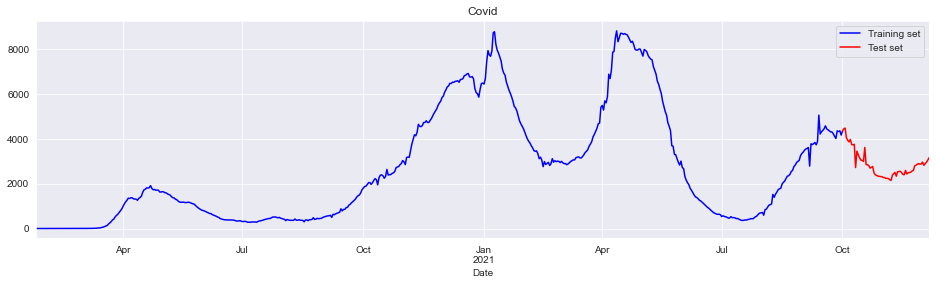

In [217]:
df["Canada"][:'2021-10-01'].plot(figsize=(16,4),legend=True, color='blue')
df["Canada"]['2021-10-01':].plot(figsize=(16,4),legend=True,color='red')

plt.legend(['Training set','Test set '])
plt.title('New comfrmed Covid-19 cases in Canada')
plt.show()

# Creating time series

In [265]:
#Split data into train and test sets
training_set = df[:'2021-10-01'].iloc[:,-3:].values
test_set = df['2021-10-01':].iloc[:,-1:].values

In [266]:
#Scaling data
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

In [267]:
X_train = []
y_train = []
for i in range(30,len(training_set)):
    X_train.append(training_set_scaled[i-30:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [268]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [262]:
#Compile with an inital model with 2 LSTMs of 64 units:
model = Sequential()
model.add(CuDNNLSTM(units=64,return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(CuDNNLSTM(units=64))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='rmsprop',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=20,batch_size=16)

Epoch 1/20
37/37 [==============================] - 2s 11ms/step - loss: 0.0156
Epoch 2/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 3/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 4/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 5/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 6/20
37/37 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 7/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 8/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9/20
37/37 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 10/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 11/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0017
Epoch 12/20
37/37 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 13/20
37/37 [=============================

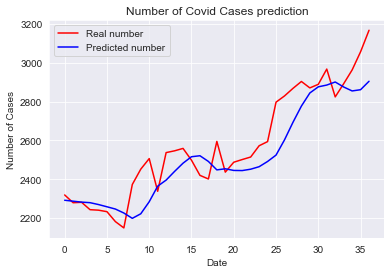

MSE =  123.32409711331518


In [263]:
dataset_total = pd.concat((df[:'2021-10-01'].iloc[:,-3:],df['2021-10-01':].iloc[:,-1:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

X_test = []
y_test = []

for i in range(30,len(test_set)):
    X_test.append(test_set_scaled[i-30:i,0])
    y_test.append(test_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_predicted = model.predict(X_test)
y_predicted = sc.inverse_transform(y_predicted)
y_test = sc.inverse_transform(y_test.reshape(-1, 1))
plt.plot(y_test, color='red',label='Real number')
plt.plot(y_predicted, color='blue',label='Predicted number')
plt.title('Number of Covid Cases prediction')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

MSE1=mean_squared_error(y_test, y_predicted, squared=False)
print("MSE = ", MSE1)

# Optimizing the model with Tensorboard

In [236]:
#Trying 4*3*3=36 different combinations of LSTM cells and dense layers:

dense_layers = [0, 1, 2, 3]
units = [32, 64, 128]
n_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for unit in units:
        for layers in n_layers:
            NAME = "{}-lstm-{}-units-{}-dense-{}".format(layers, unit, dense_layer, int(time.time()))
            print(NAME)
            
            model = Sequential()

            model.add(CuDNNLSTM(units=unit, return_sequences= layers-1>0, input_shape=(X_train.shape[1],1)))

            for l in range(layers-1):
                model.add(CuDNNLSTM(units=unit , return_sequences= l < layers-2 ))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(unit))

            model.add(Dense(1))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            
            
            # Compiling the RNN
            model.compile(optimizer='rmsprop',loss='mean_squared_error', metrics=['MeanAbsoluteError'])
            # Fitting to the training set
            model.fit(X_train,y_train,epochs=10,batch_size=32, validation_split=0.3,callbacks=[tensorboard])

1-lstm-32-units-0-dense-1638933226
Epoch 1/10
13/13 [==============================] - 1s 38ms/step - loss: 0.0625 - mean_absolute_error: 0.1726 - val_loss: 0.0109 - val_mean_absolute_error: 0.0850
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 0.0050 - mean_absolute_error: 0.0586 - val_loss: 0.0140 - val_mean_absolute_error: 0.0957
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0489 - val_loss: 0.0073 - val_mean_absolute_error: 0.0743
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 0.0032 - mean_absolute_error: 0.0412 - val_loss: 0.0070 - val_mean_absolute_error: 0.0703
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_absolute_error: 0.0391 - val_loss: 0.0059 - val_mean_absolute_error: 0.0647
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_absolute_error: 0.0395 - val_loss: 0.0057 - val_mean_absolute_e

In [269]:
model=Sequential()
model.add(CuDNNLSTM(units=128, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=1))
# Compiling the RNN
model.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train,y_train,epochs=50,batch_size=16)

Epoch 1/50
37/37 [==============================] - 1s 9ms/step - loss: 0.0250
Epoch 2/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 3/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0040
Epoch 4/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 5/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 6/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 7/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 8/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 9/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 10/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 11/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 12/50
37/37 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 13/50
37/37 [==============================

In [245]:
#Choose batch size and epochs:
batchs = [8, 16, 32, 64]
epochs = [20, 40, 60,80,100]
for batch in batchs:
    for epoch in epochs:
        NAME = "{}-batch{}-epoch-{}".format(batch, epoch, int(time.time()))
        print(NAME)
        tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
        model.fit(X_train,y_train,epochs=epoch,batch_size=batch, validation_split=0.3,callbacks=[tensorboard])

8-batch20-epoch-1638934209
Epoch 1/20
52/52 [==============================] - 1s 9ms/step - loss: 2.1597e-04 - val_loss: 7.2190e-05
Epoch 2/20
52/52 [==============================] - 0s 5ms/step - loss: 2.5379e-04 - val_loss: 1.1614e-04
Epoch 3/20
52/52 [==============================] - 0s 7ms/step - loss: 2.1941e-04 - val_loss: 1.7894e-04
Epoch 4/20
52/52 [==============================] - 0s 6ms/step - loss: 1.9843e-04 - val_loss: 6.7808e-05
Epoch 5/20
52/52 [==============================] - 0s 6ms/step - loss: 1.9920e-04 - val_loss: 2.0117e-04
Epoch 6/20
52/52 [==============================] - 0s 5ms/step - loss: 1.9172e-04 - val_loss: 7.0830e-04
Epoch 7/20
52/52 [==============================] - 0s 6ms/step - loss: 2.2169e-04 - val_loss: 1.4726e-04
Epoch 8/20
52/52 [==============================] - 0s 7ms/step - loss: 2.3553e-04 - val_loss: 6.9687e-05
Epoch 9/20
52/52 [==============================] - 0s 7ms/step - loss: 2.2482e-04 - val_loss: 1.6723e-04
Epoch 10/20
52/52 [

In [275]:
#Compile the optimzed model based on the results:
model.compile(optimizer='rmsprop',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
19/19 [==============================] - 1s 16ms/step - loss: 9.6900e-04
Epoch 2/50
19/19 [==============================] - 0s 6ms/step - loss: 5.9546e-04
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 8.0092e-04
Epoch 4/50
19/19 [==============================] - 0s 5ms/step - loss: 6.8247e-04
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 7.6693e-04
Epoch 6/50
19/19 [==============================] - 0s 5ms/step - loss: 7.8481e-04
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 6.6378e-04
Epoch 8/50
19/19 [==============================] - 0s 5ms/step - loss: 6.8535e-04
Epoch 9/50
19/19 [==============================] - 0s 5ms/step - loss: 7.6495e-04
Epoch 10/50
19/19 [==============================] - 0s 5ms/step - loss: 7.3422e-04
Epoch 11/50
19/19 [==============================] - 0s 6ms/step - loss: 6.2568e-04
Epoch 12/50
19/19 [==============================] - 0s 5ms/step - loss: 7.1974e-04


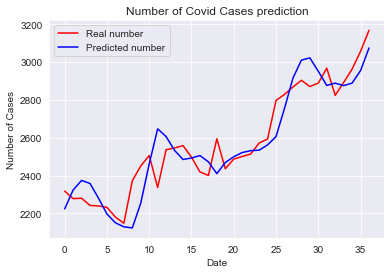

MSE =  106.18087306590509


In [277]:
dataset_total = pd.concat((df[:'2021-10-01'].iloc[:,-3:],df['2021-10-01':].iloc[:,-1:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 30:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

X_test = []
y_test = []

for i in range(30,len(test_set)):
    X_test.append(test_set_scaled[i-30:i,0])
    y_test.append(test_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_predicted = model.predict(X_test)
y_predicted = sc.inverse_transform(y_predicted)
y_test = sc.inverse_transform(y_test.reshape(-1, 1))
plt.plot(y_test, color='red',label='Real number')
plt.plot(y_predicted, color='blue',label='Predicted number')
plt.title('Number of Covid Cases prediction')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()
MSE2=mean_squared_error(y_test, y_predicted, squared=False)
print('MSE = ', MSE2)

In [2]:
print('Mean error reduction achieved is:', round((MSE1-MSE2)/MSE1*100), '%')

Mean error reduction achieved is: 14 %
